In [9]:
import numpy as np
import pandas as pd
import os
import random
import cv2
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [10]:
import tensorflow as tf
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [15]:
train_dir='/kaggle/input/animal-dataset/animal_dataset_intermediate/train'
test_dir='/kaggle/input/animal-dataset/animal_dataset_intermediate/test'

In [16]:
Name=[]
for file in os.listdir(train_dir):
    Name+=[file]
print(Name)
print(len(Name))

['farfalla_train', 'pecora_train', 'scoiattolo_train', 'elefante_train', 'mucca_train']
5


In [17]:
N=[]
for i in range(len(Name)):
    N+=[i]
normal_mapping=dict(zip(Name,N)) 
reverse_mapping=dict(zip(N,Name)) 

In [19]:
import os
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import load_img, img_to_array

trainx0 = []
trainy0 = []
trainpaths = []
count = 0

for file in Name:
    path = os.path.join(train_dir, file)
    for im in tqdm(os.listdir(path)):
        if im[-4:] != '.txt':
            trainpaths.append(os.path.join(path, im))    
            image = load_img(os.path.join(path, im), color_mode='rgb', target_size=(48, 48))
            image = img_to_array(image)
            image = image / 255.0
            trainx0.append(image)
            trainy0.append(count)
    count = count + 1


100%|██████████| 1680/1680 [00:06<00:00, 249.28it/s]


In [21]:

testx0 = []
testpaths = []

for im in tqdm(os.listdir(test_dir)):
    if im[-4:] != '.txt':
        testpaths.append(os.path.join(test_dir, im))    
        image = load_img(os.path.join(test_dir, im), color_mode='rgb', target_size=(48, 48))
        image = img_to_array(image)
        image = image / 255.0
        testx0.append(image)


100%|██████████| 910/910 [00:06<00:00, 150.02it/s]


# Show images

In [22]:
num0=random.sample(range(len(trainpaths)),k=9)
print(num0)

[2181, 2398, 2282, 3829, 7327, 1321, 5790, 3409, 3502]


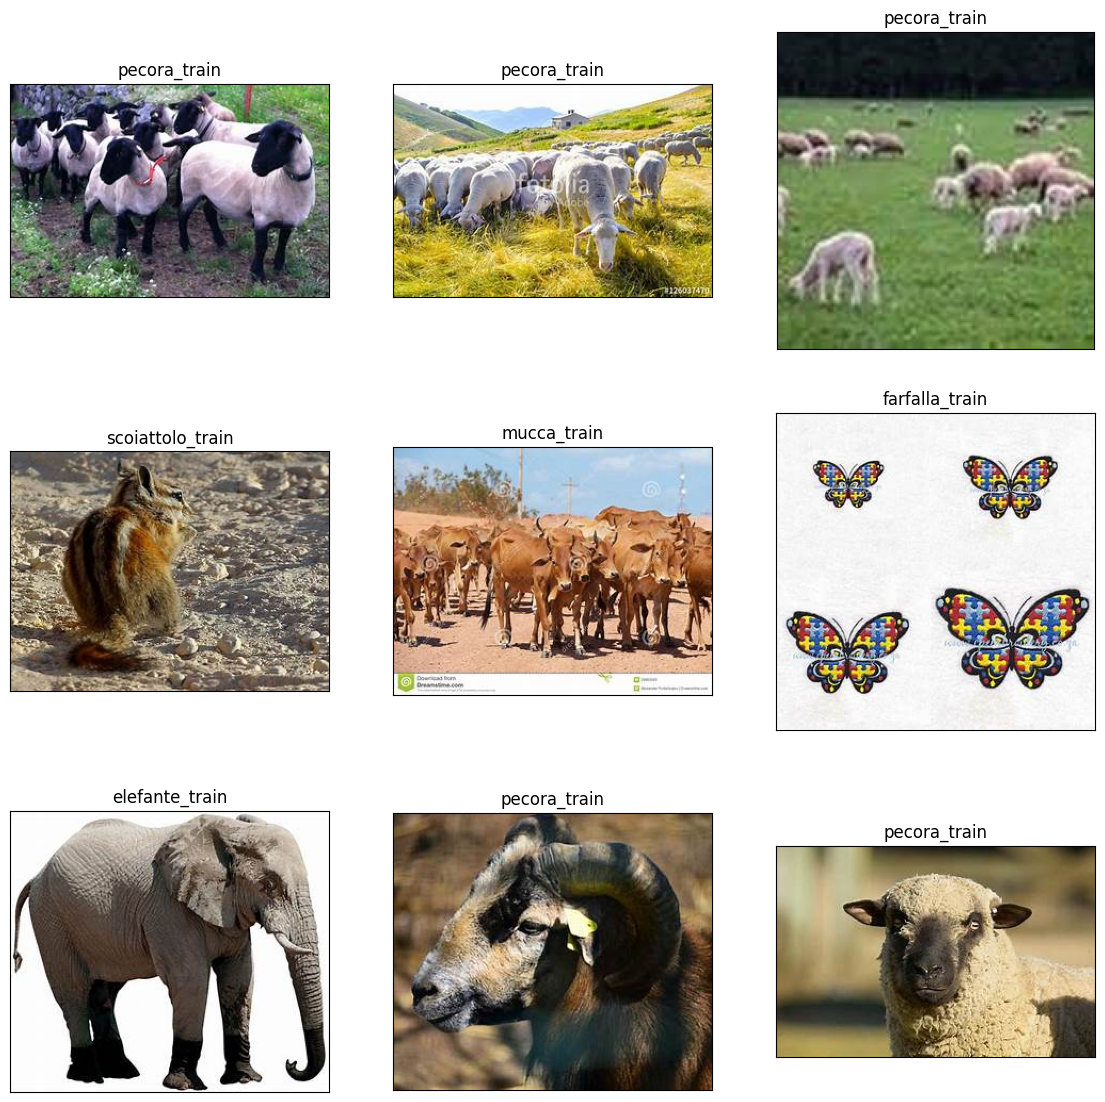

In [23]:
fig,axs = plt.subplots(3,3,figsize=(14,14))
for i in range(9):
    image_input = cv2.imread(trainpaths[num0[i]])
    r=i//3
    c=i%3
    axs[r][c].set_xticks([])
    axs[r][c].set_yticks([])
    axs[r][c].set_title(reverse_mapping[trainy0[num0[i]]])
    ax=axs[r][c].imshow(cv2.cvtColor(image_input, cv2.COLOR_BGR2RGB))
plt.show()

In [24]:
labels = open('/kaggle/input/yolo-coco-data/coco.names').read().strip().split('\n')
print(labels)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [25]:
weights_path = '/kaggle/input/yolo-coco-data/yolov3.weights'
configuration_path = '/kaggle/input/yolo-coco-data/yolov3.cfg'
probability_minimum = 0.5
threshold = 0.3

In [27]:
network = cv2.dnn.readNetFromDarknet(configuration_path, weights_path)
layers_names_all = network.getLayerNames()
layers_names_output = [layers_names_all[i - 1] for i in network.getUnconnectedOutLayers()]

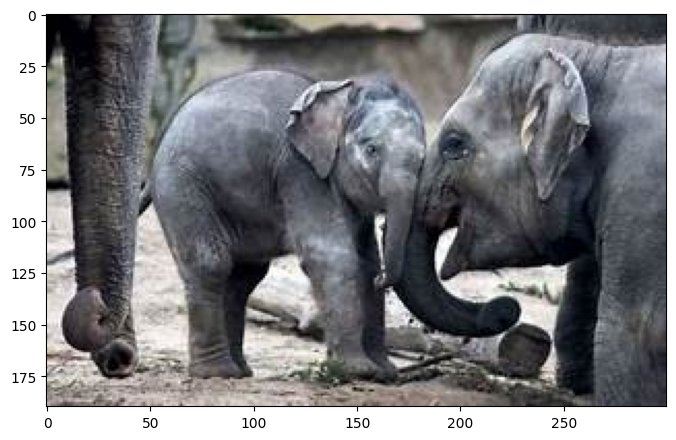

In [28]:
image_input = cv2.imread(trainpaths[6000])

%matplotlib inline
plt.rcParams['figure.figsize'] = (8,8)
plt.imshow(cv2.cvtColor(image_input, cv2.COLOR_BGR2RGB))
plt.show()

In [29]:
blob = cv2.dnn.blobFromImage(image_input, 1/255.0, (416,416), swapRB=True, crop=False)
blob_to_show = blob[0,:,:,:].transpose(1,2,0)
network.setInput(blob)
output_from_network = network.forward(layers_names_output)
np.random.seed(42)
colours = np.random.randint(0, 255, size=(len(labels), 3), dtype='uint8')

In [30]:
bounding_boxes = []
confidences = []
class_numbers = []
h,w = image_input.shape[:2]

for result in output_from_network:
    for detection in result:
        scores = detection[5:]
        class_current = np.argmax(scores)
        confidence_current = scores[class_current]
        if confidence_current > probability_minimum:
            box_current = detection[0:4] * np.array([w, h, w, h])
            x_center, y_center, box_width, box_height = box_current.astype('int')
            x_min = int(x_center-(box_width/2))
            y_min = int(y_center-(box_height/2))
            bounding_boxes.append([x_min, y_min, int(box_width), int(box_height)])
            confidences.append(float(confidence_current))
            class_numbers.append(class_current)
           

In [31]:
results = cv2.dnn.NMSBoxes(bounding_boxes, confidences, probability_minimum, threshold)

if len(results) > 0:
    for i in results.flatten():
        x_min, y_min = bounding_boxes[i][0], bounding_boxes[i][1]
        box_width, box_height = bounding_boxes[i][2], bounding_boxes[i][3]
        colour_box_current = [int(j) for j in colours[class_numbers[i]]]
        cv2.rectangle(image_input, (x_min, y_min), (x_min + box_width, y_min + box_height),
                      colour_box_current, 5)
        text_box_current = '{}: {:.4f}'.format(labels[int(class_numbers[i])], confidences[i])
        cv2.putText(image_input, text_box_current, (x_min, y_min - 7), cv2.FONT_HERSHEY_SIMPLEX,
                    1.5, colour_box_current, 5)

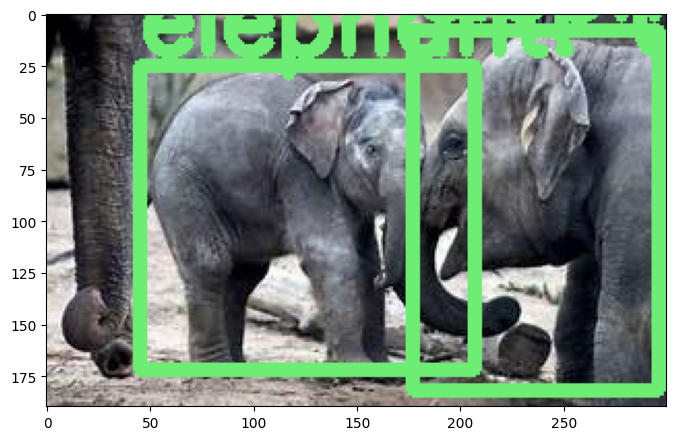

In [32]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (8,8)
plt.imshow(cv2.cvtColor(image_input, cv2.COLOR_BGR2RGB))
plt.show()

In [33]:
def ImagePath(path):
    
    bounding_boxes = []
    confidences = []
    class_numbers = []
    
    image_input = cv2.imread(path)
    blob = cv2.dnn.blobFromImage(image_input, 1/255.0, (416,416), swapRB=True, crop=False)
    blob_to_show = blob[0,:,:,:].transpose(1,2,0)
    network.setInput(blob)
    output_from_network = network.forward(layers_names_output)
    h,w = image_input.shape[:2]

    for result in output_from_network:
        for detection in result:
            scores = detection[5:]
            class_current = np.argmax(scores)
            confidence_current = scores[class_current]
            if confidence_current > probability_minimum:
                box_current = detection[0:4] * np.array([w, h, w, h])
                x_center, y_center, box_width, box_height = box_current.astype('int')
                x_min = int(x_center-(box_width/2))
                y_min = int(y_center-(box_height/2))
                bounding_boxes.append([x_min, y_min, int(box_width), int(box_height)])
                confidences.append(float(confidence_current))
                class_numbers.append(class_current)

    %matplotlib inline
    plt.rcParams['figure.figsize'] = (8,8)
    plt.imshow(cv2.cvtColor(image_input, cv2.COLOR_BGR2RGB))
    plt.show()
    
    labels2=[]
    for item in sorted(set(class_numbers)):
        labels2+=[labels[item]]
        
    return labels2

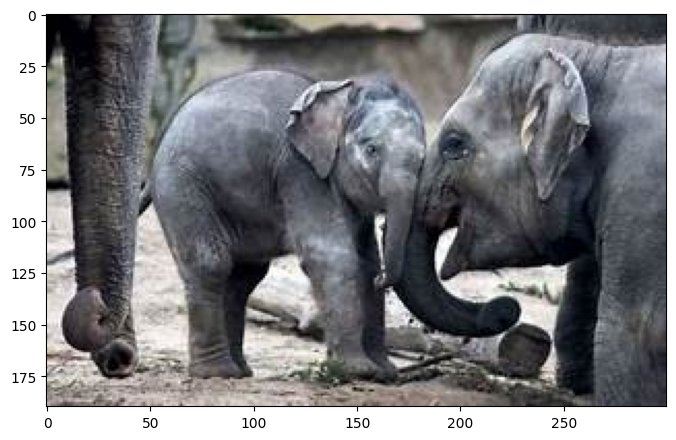

['elephant']

In [34]:
ImagePath(trainpaths[6000])

In [35]:
tobjects=[]

def ExtractImage(path, show=False):
    
    bounding_boxes = []
    confidences = []
    class_numbers = []

    image_input = cv2.imread(path)
    blob = cv2.dnn.blobFromImage(image_input, 1/255.0, (416,416), swapRB=True, crop=False)
    blob_to_show = blob[0,:,:,:].transpose(1,2,0)
    network.setInput(blob)
    output_from_network = network.forward(layers_names_output)
    h,w = image_input.shape[:2]

    for result in output_from_network:
        for detection in result:
            scores = detection[5:]
            class_current = np.argmax(scores)
            confidence_current = scores[class_current]
            if confidence_current > probability_minimum:
                box_current = detection[0:4] * np.array([w, h, w, h])
                x_center, y_center, box_width, box_height = box_current.astype('int')
                x_min = int(x_center-(box_width/2))
                y_min = int(y_center-(box_height/2))
                
                if x_min<0:
                    x_min=0
                if y_min<0:
                    y_min=0
                
                obj=image_input[int(y_min):int(y_min+box_height),int(x_min):int(x_min+box_width)]
              
                obj1 = Image.fromarray(np.uint8(obj))
                obj2 = np.asarray(obj1.resize((64,64)))/255.0 
                tobjects.append(obj2)

                if show:
                    _ = plt.figure(figsize=(3,3))
                    _ = plt.xticks([])
                    _ = plt.yticks([])
                    _ = plt.imshow(cv2.cvtColor(obj, cv2.COLOR_BGR2RGB))

    return None

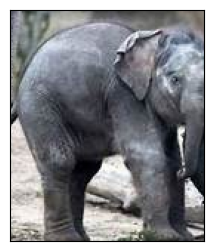

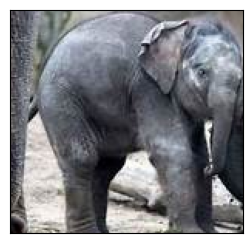

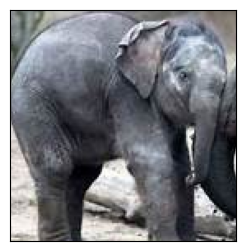

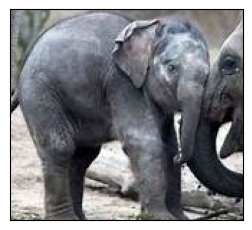

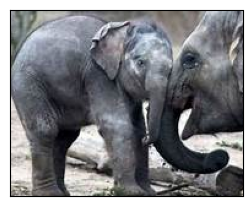

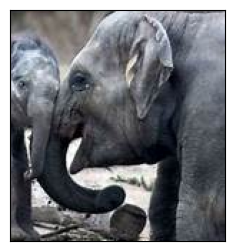

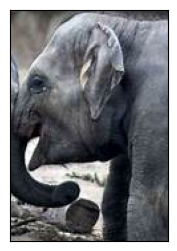

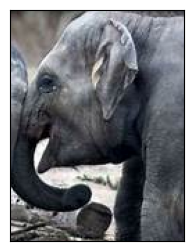

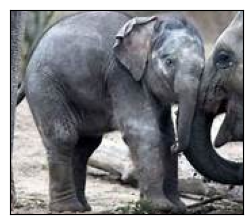

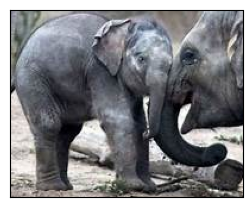

In [36]:
ExtractImage(trainpaths[6000],show=True)

In [38]:
import os
from tqdm import tqdm
import warnings
from tensorflow.keras.preprocessing.image import load_img, img_to_array

warnings.filterwarnings("ignore", category=UserWarning, message=".*iCCP: known incorrect sRGB profile.*")

def ExtractImage(image_path, show=False):
    # Your implementation of ExtractImage function
    pass

for i in tqdm(range(len(trainpaths))):
    ExtractImage(trainpaths[i], show=False)


100%|██████████| 8196/8196 [00:00<00:00, 825921.76it/s]


In [39]:
trainobjects_ar=np.array(tobjects)
print(trainobjects_ar.shape)
np.save('trainobjects',trainobjects_ar)
del trainobjects_ar

(790, 64, 64, 3)


In [40]:
for i in tqdm(range(len(testpaths))):
    ExtractImage(testpaths[i],show=False)

100%|██████████| 910/910 [00:00<00:00, 620217.20it/s]


In [41]:
testobjects_ar=np.array(tobjects)
print(testobjects_ar.shape)
np.save('testobjects',testobjects_ar)

(790, 64, 64, 3)


In [42]:
num1=random.sample(range(len(testobjects_ar)),k=9)
print(num1)

[567, 130, 271, 783, 403, 622, 270, 423, 693]


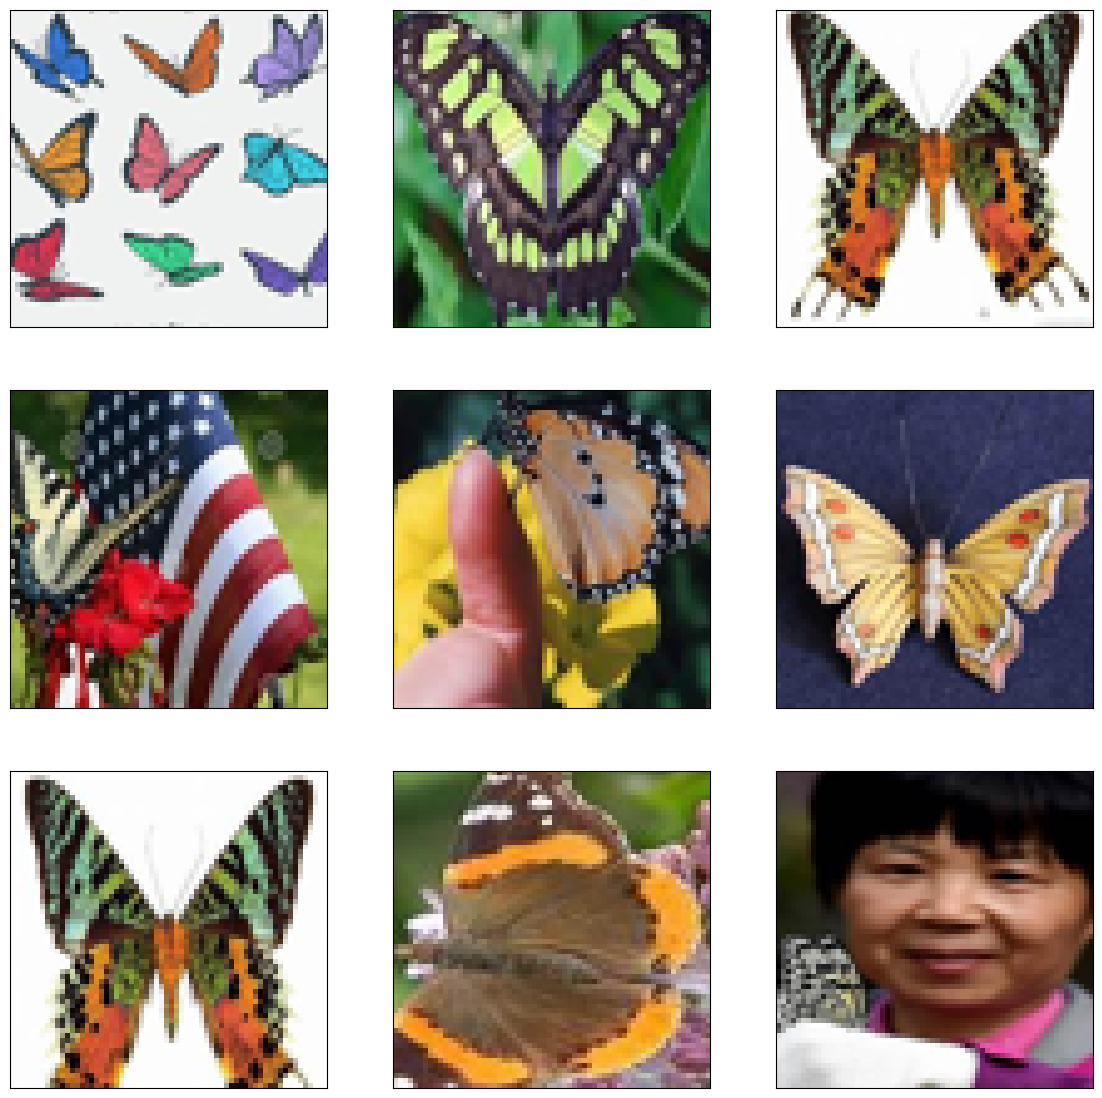

In [43]:
fig,axs = plt.subplots(3,3,figsize=(14,14))
for i in range(9):
    r=i//3
    c=i%3
    axs[r][c].set_xticks([])
    axs[r][c].set_yticks([])
    ax=axs[r][c].imshow(cv2.cvtColor(testobjects_ar[num1[i]].astype('float32'),cv2.COLOR_BGR2RGB))
plt.show()